In [1]:
import time
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import pyaudio
import librosa
import librosa.display
import realtime_analysis as ra

In [2]:
plt.rcParams["figure.figsize"] = (14, 4)

# record/load audio

In [3]:
RATE = 44100
CHANNELS = 1
SAMPLES_PER_BUFFER = 1024
duration = 8
total_length = int(8*RATE)
print("buffer length:", SAMPLES_PER_BUFFER/RATE)

x = np.zeros(total_length, dtype=np.float32)
t = librosa.samples_to_time(np.arange(x.shape[0]), sr=RATE)
x_index = 0
def input_callback(in_data, frame_count, time_info, status):
    global x_index
    
    if x_index+frame_count > x.shape[0]:
        return None, pyaudio.paComplete

    audio_data = np.frombuffer(in_data, dtype=np.float32)
    x[x_index:x_index+frame_count] = audio_data
    x_index += frame_count

    return in_data, pyaudio.paContinue

print("recording...")

p = pyaudio.PyAudio()

input_stream = p.open(format=pyaudio.paFloat32,
                      channels=CHANNELS,
                      rate=RATE,
                      input=True,
                      output=False,
                      frames_per_buffer=SAMPLES_PER_BUFFER,
                      stream_callback=input_callback)
input_stream.start_stream()

while input_stream.is_active():
    time.sleep(0.1)

input_stream.stop_stream()
input_stream.close()

p.terminate()

print("finish!")

buffer length: 0.023219954648526078
recording...
finish!


In [4]:
x, RATE = librosa.load("test2.wav")
t = librosa.samples_to_time(np.arange(x.shape[0]), sr=RATE)

print("sample timespan:", x.shape[0]/RATE)

sample timespan: 6.058684807256236
sample resolution: 4.5351473922902495e-05
frame resolution: 0.023219954648526078


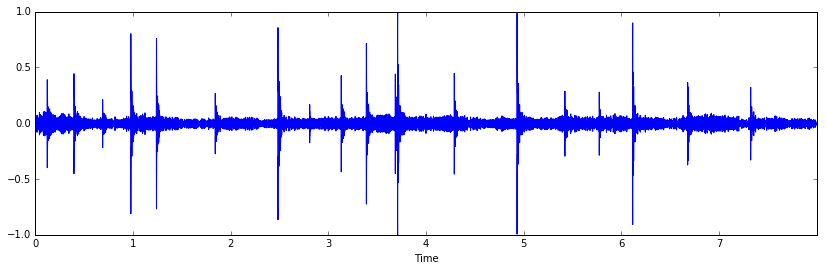

In [4]:
librosa.display.waveplot(x, RATE)

# spectrum

In [5]:
WIN_LENGTH = 1024
HOP_LENGTH = 512
print("sample resolution:", 1/RATE)
print("frame resolution:", HOP_LENGTH/RATE)

sample resolution: 2.2675736961451248e-05
frame resolution: 0.011609977324263039


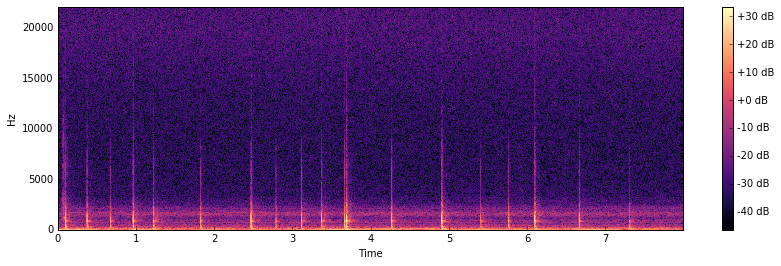

In [6]:
X = librosa.stft(x, n_fft=WIN_LENGTH, win_length=WIN_LENGTH, hop_length=HOP_LENGTH, center=False)
Xdb = librosa.amplitude_to_db(abs(X))
t_frames = librosa.frames_to_time(np.arange(X.shape[1]), sr=RATE, hop_length=HOP_LENGTH, n_fft=WIN_LENGTH)

librosa.display.specshow(Xdb, sr=RATE, hop_length=HOP_LENGTH, x_axis="time", y_axis="linear")
plt.colorbar(format="%+2.0f dB")

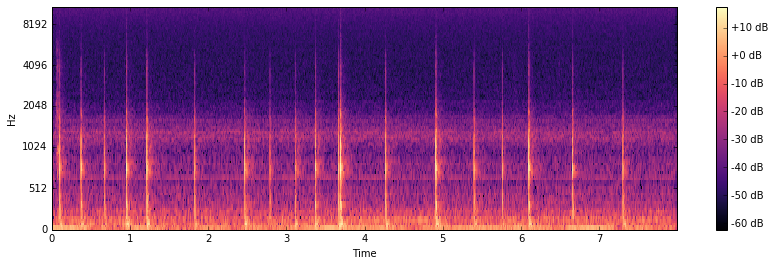

In [7]:
M = librosa.feature.melspectrogram(S=abs(X)**2, sr=RATE, n_fft=WIN_LENGTH, win_length=WIN_LENGTH, hop_length=HOP_LENGTH)
Mdb = librosa.power_to_db(M)

librosa.display.specshow(Mdb, sr=RATE, hop_length=HOP_LENGTH, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")

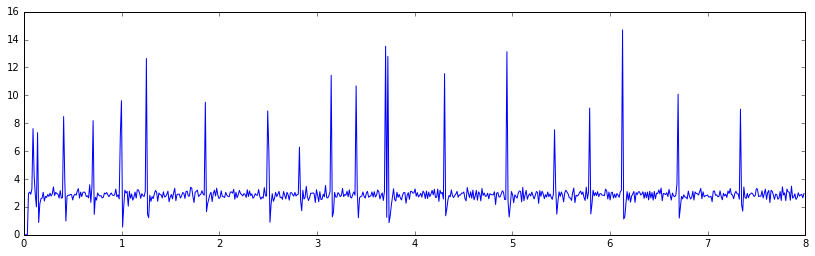

In [30]:
onset_env = librosa.onset.onset_strength(S=Xdb, sr=RATE)
plt.plot(t_frames, onset_env)

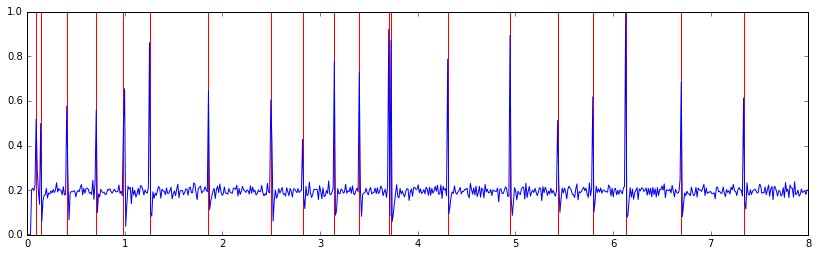

In [31]:
onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env)
onset_times = librosa.frames_to_time(onset_frames, sr=RATE, hop_length=HOP_LENGTH, n_fft=WIN_LENGTH)
onset_samples = librosa.frames_to_samples(onset_frames, hop_length=HOP_LENGTH, n_fft=WIN_LENGTH)

plt.plot(t_frames, onset_env)
plt.vlines(onset_times, ymin=0, ymax=1, color="r")

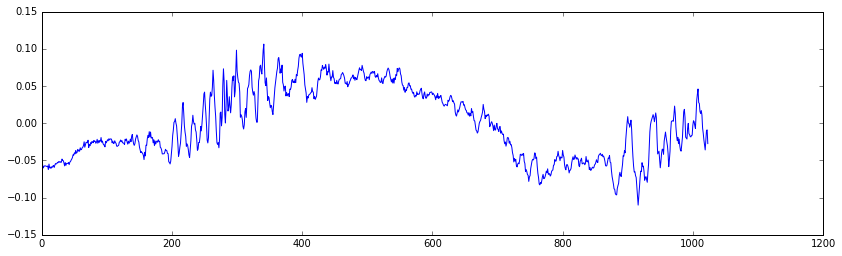

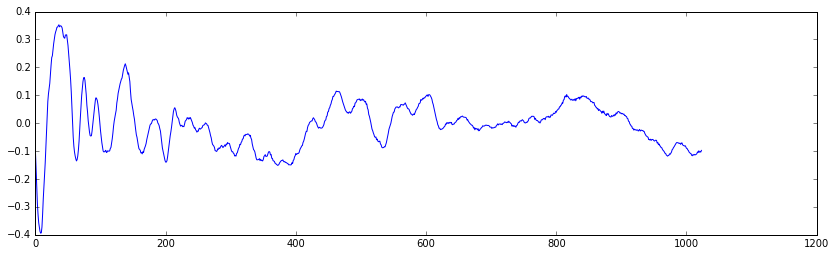

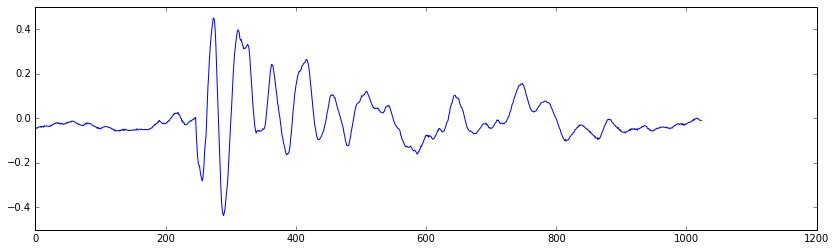

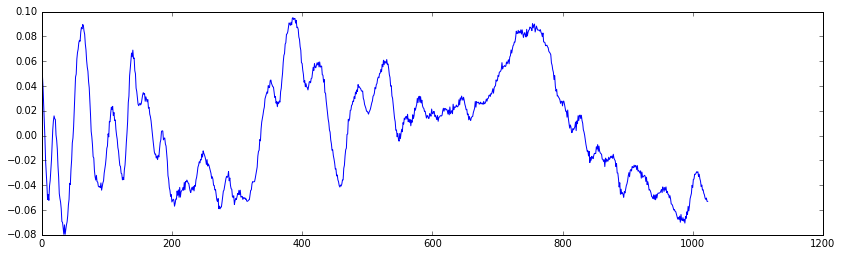

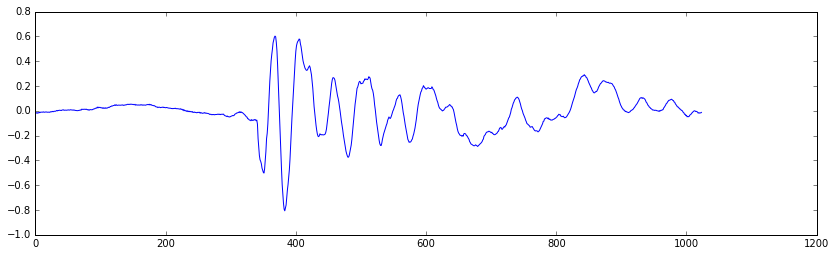

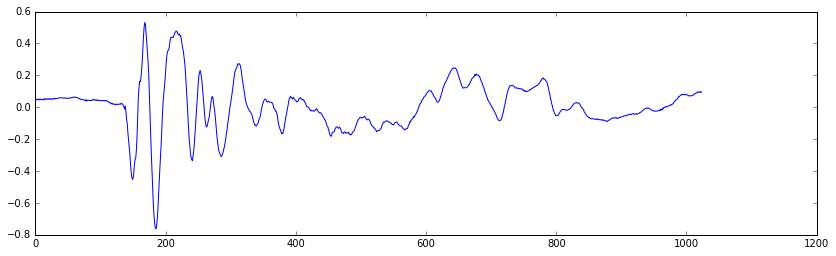

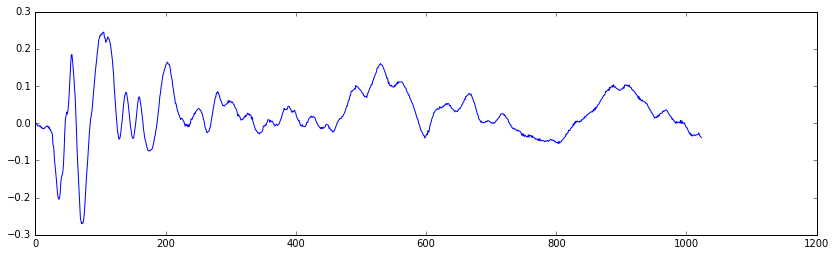

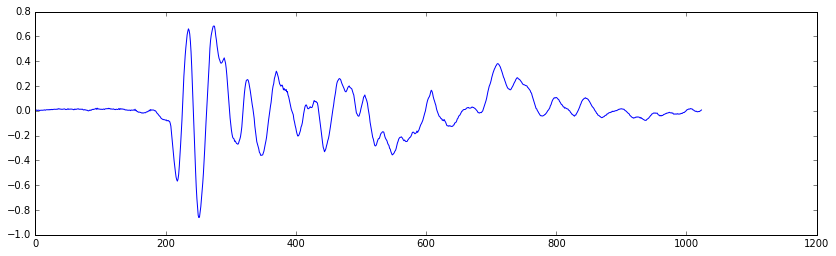

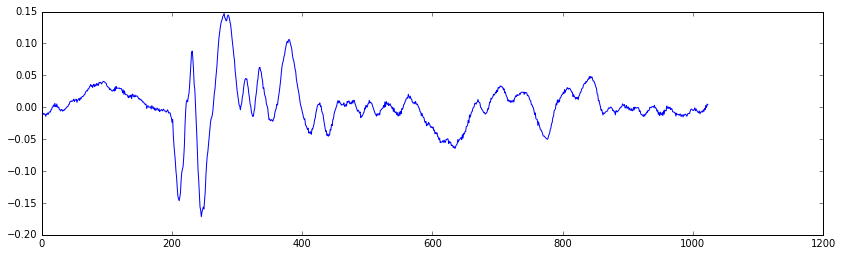

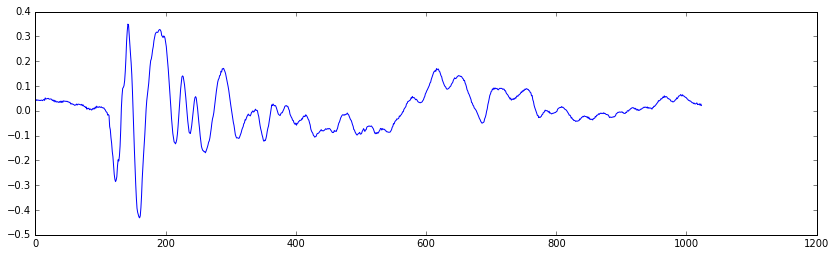

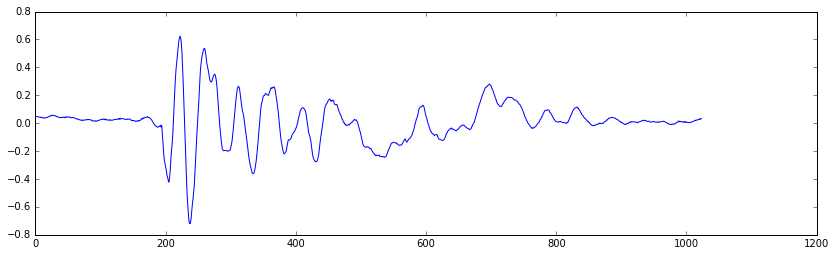

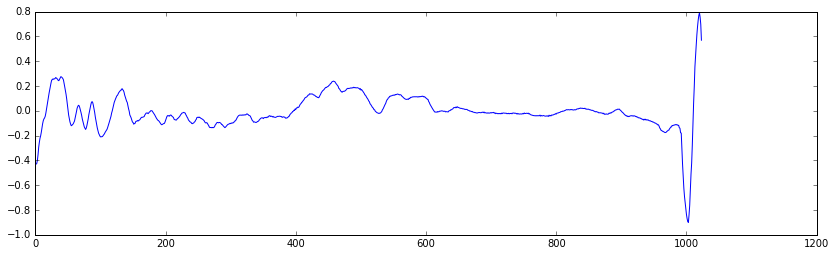

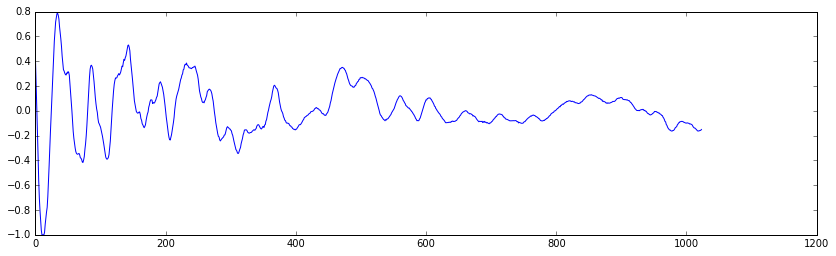

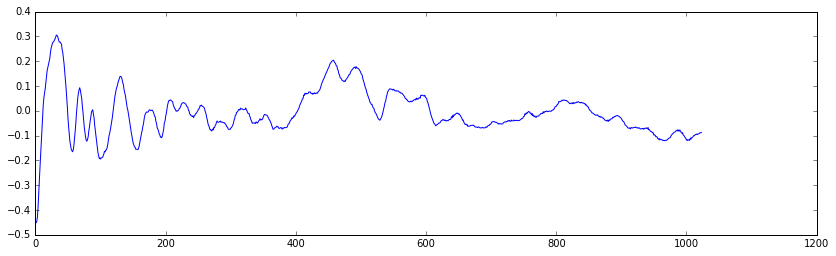

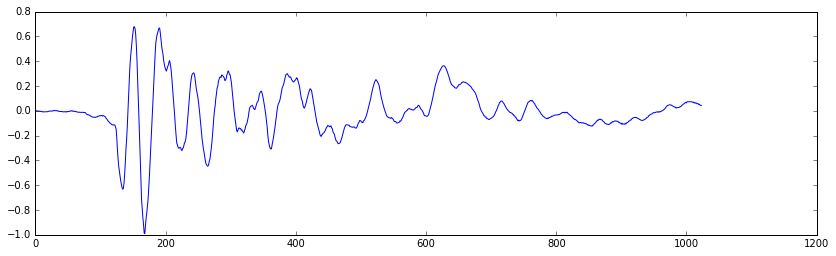

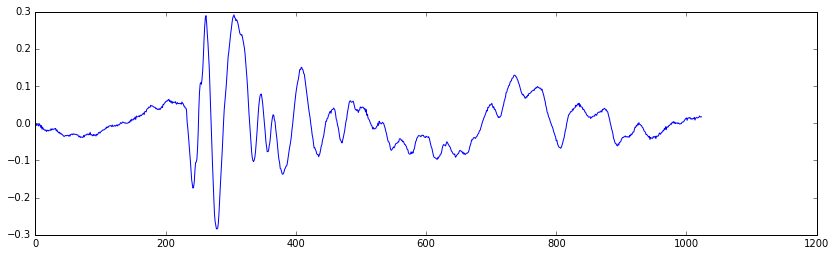

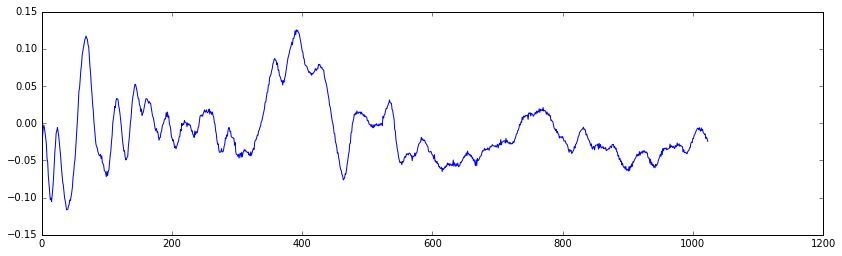

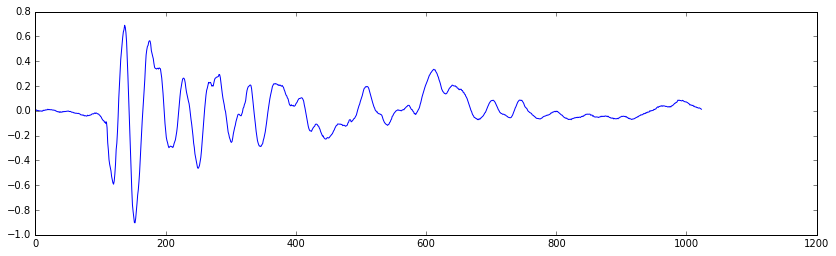

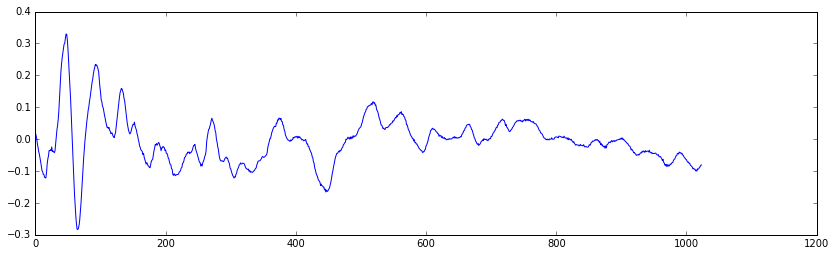

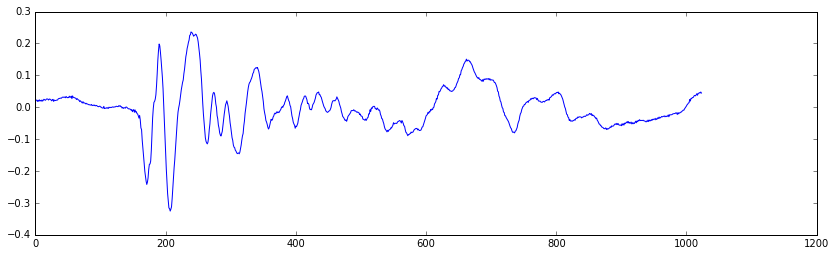

In [32]:
onset_block = []
for index in onset_samples:
    onset_waveform = x[index-HOP_LENGTH*2:index]
    onset_block.append(onset_waveform)
    plt.plot(onset_waveform)
    plt.show()

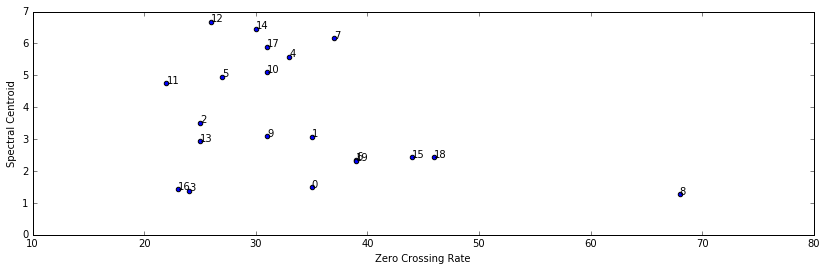

In [33]:
zcr = np.array([librosa.zero_crossings(xs).sum() for xs in onset_block])
cen = np.array([scipy.linalg.norm(xs) for xs in onset_block])

plt.scatter(zcr, cen)
ax = plt.gca()
for i in range(len(zcr)):
    ax.annotate(i, (zcr[i], cen[i]))
plt.xlabel("Zero Crossing Rate")
plt.ylabel("Spectral Centroid")

# energy

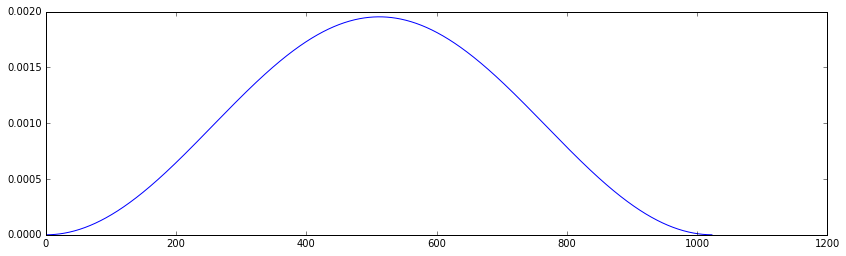

In [12]:
window = scipy.signal.get_window("hann", WIN_LENGTH)
window /= window.sum()
plt.plot(window)

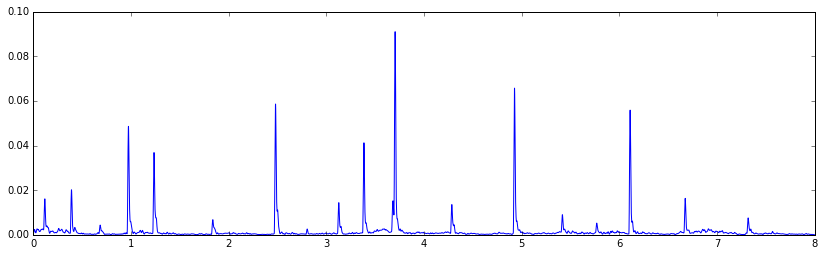

In [13]:
env = np.convolve(x**2, window, mode="same")
plt.plot(t, env)

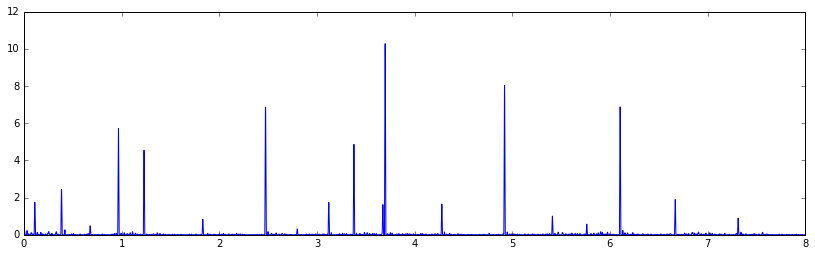

In [14]:
plt.plot(t[:-1], np.maximum(0.0, np.diff(env)/(t[1]-t[0])))

# realtime

In [26]:
import imp
imp.reload(ra)

<module 'realtime_analysis' from '/home/qislab-presentation/Documents/knock/realtime_analysis.py'>

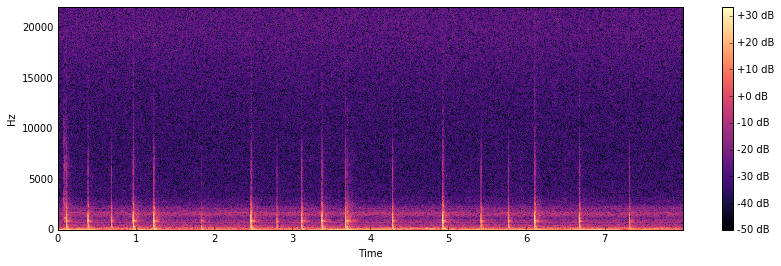

In [27]:
mel = ra.pipe(ra.frame(WIN_LENGTH, HOP_LENGTH),
              ra.power_freq(RATE, WIN_LENGTH))
next(mel)
s = []
for i in range(0, x.shape[0]-HOP_LENGTH, HOP_LENGTH):
    s.append(mel.send(x[i:i+HOP_LENGTH]))
s = np.stack(s).T

librosa.display.specshow(s, sr=RATE, hop_length=HOP_LENGTH, x_axis="time", y_axis="linear")
plt.colorbar(format="%+2.0f dB")

In [28]:
env = ra.pipe(ra.frame(WIN_LENGTH, HOP_LENGTH),
              ra.power_freq(RATE, WIN_LENGTH),
              ra.onset_strength())
next(env)
dect = ra.onset_detect(RATE, HOP_LENGTH, delta=1)
next(dect)
e = [0]
p = [False]
for i in range(0, x.shape[0]-HOP_LENGTH, HOP_LENGTH):
    e.append(env.send(x[i:i+HOP_LENGTH]))
    p.append(dect.send(e[-1]))
    
e = np.array(e)
p = np.array(p)
t = np.arange(e.shape[0])*HOP_LENGTH/RATE

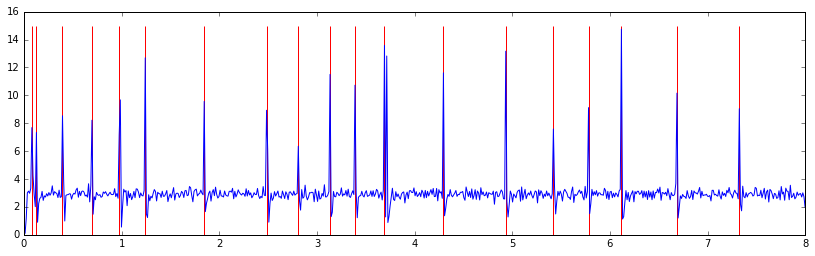

In [29]:
plt.plot(t, e)
lag = int(0.1*RATE/HOP_LENGTH)
plt.vlines(t[:-lag][p[lag:]], ymin=0, ymax=15, color="r")

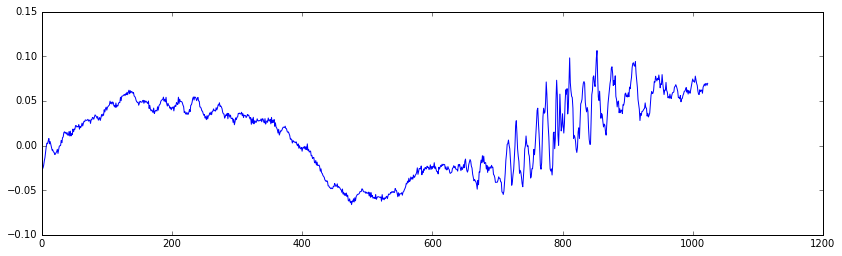

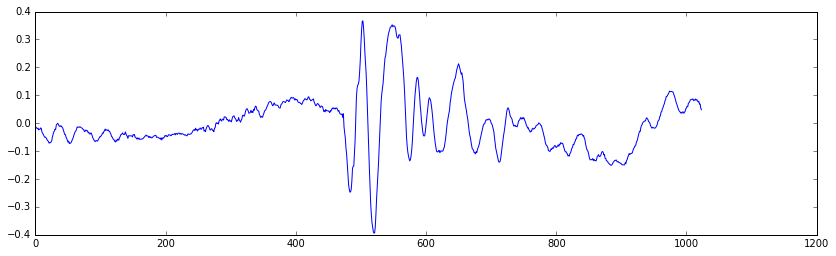

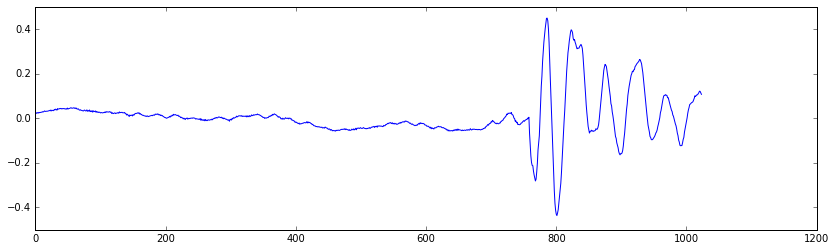

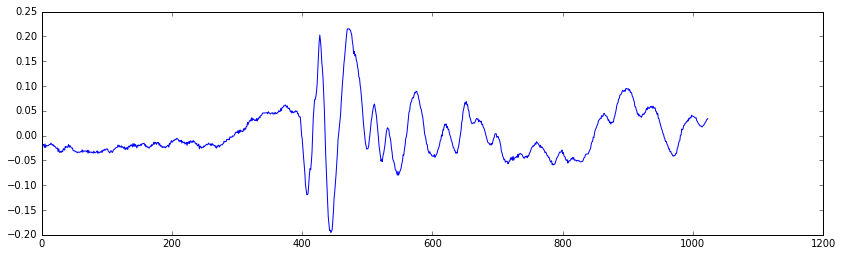

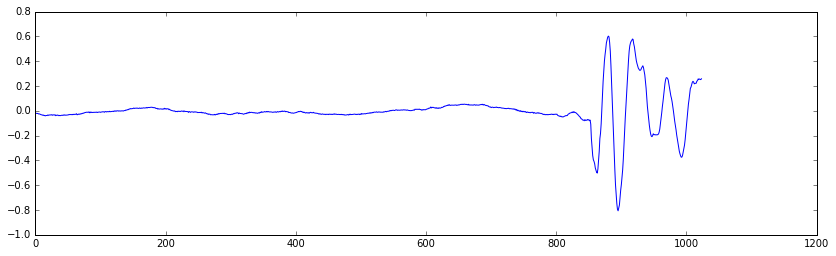

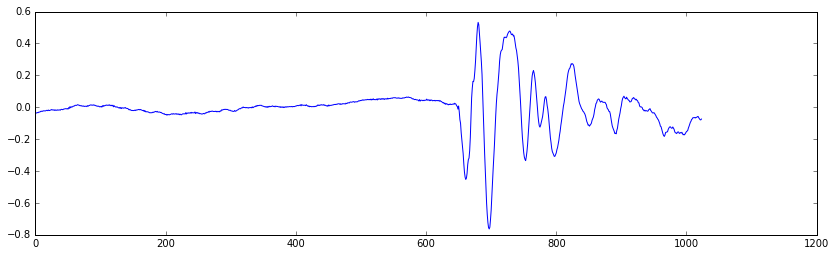

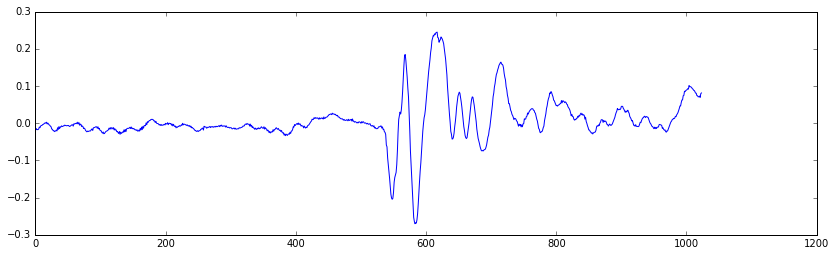

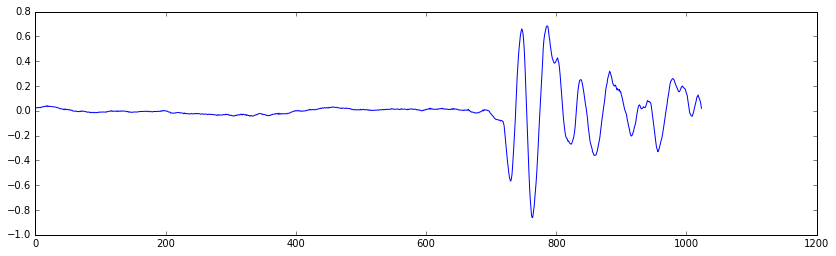

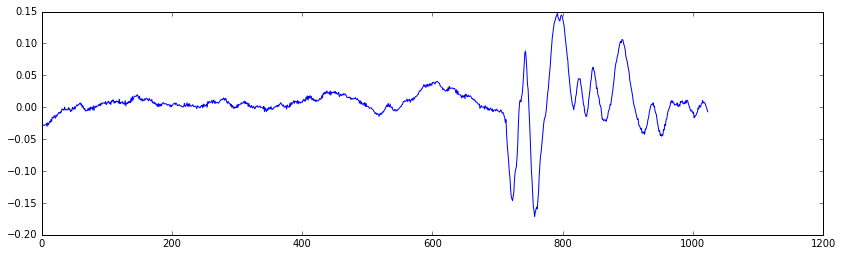

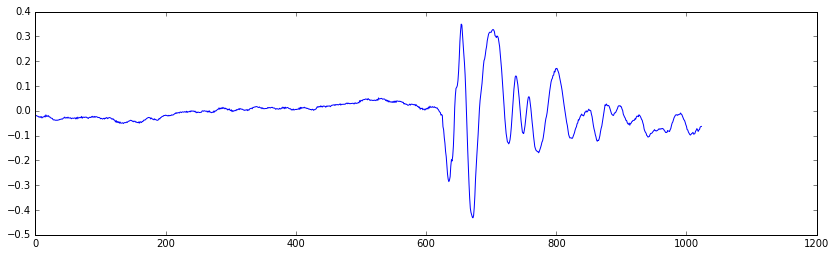

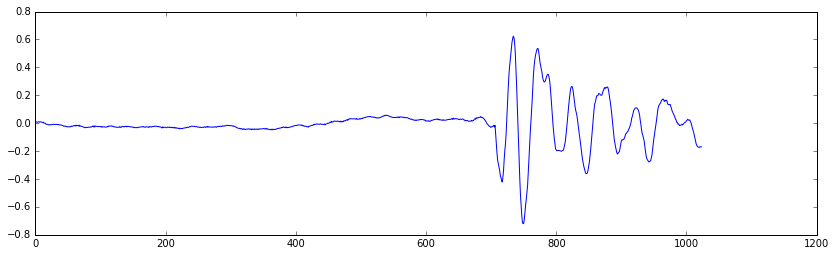

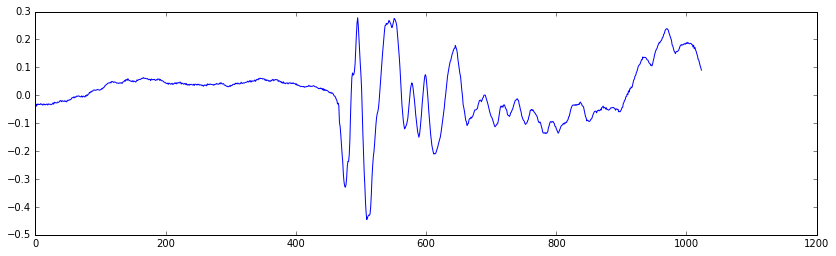

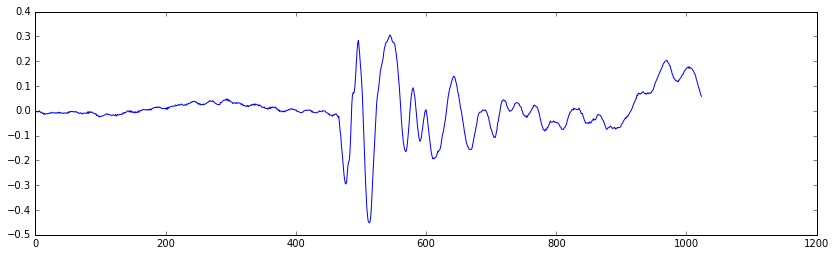

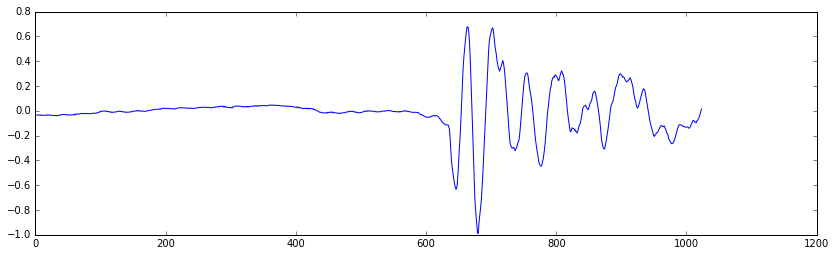

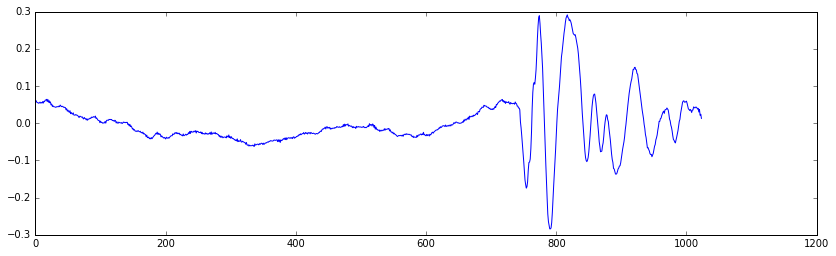

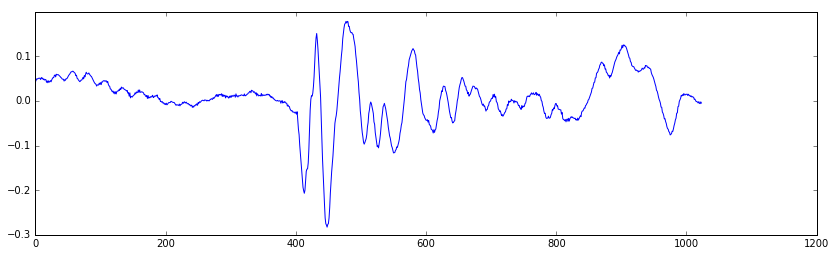

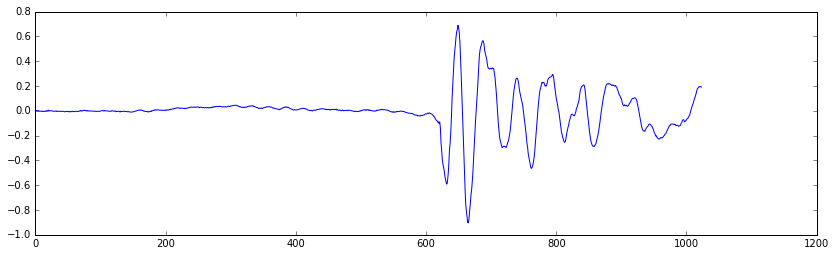

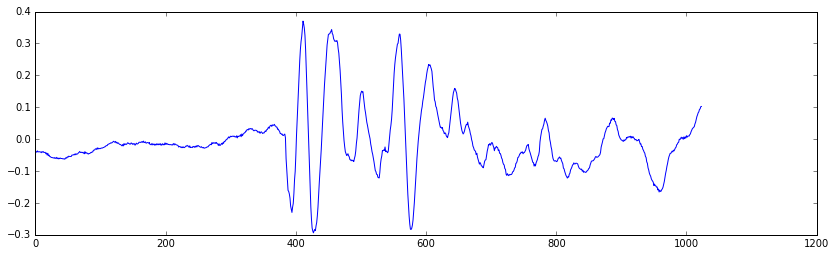

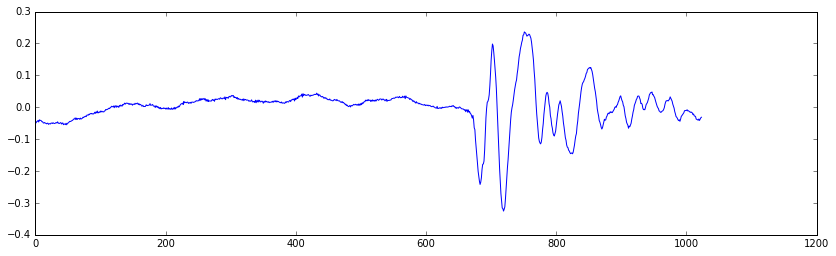

In [25]:
onset_block = []
for index_frame in np.nonzero(p[lag:])[0]:
    index = index_frame * HOP_LENGTH
    onset_waveform = x[index-HOP_LENGTH*2:index]
    onset_block.append(onset_waveform)
    plt.plot(onset_waveform)
    plt.show()